<h1><center>Práctica Aprendizaje: Airbnb.</center></h1>

<h1><center>Análisis Exploratorio de los datos</center></h1>

# Introducción

- Conjunto de datos: El conjunto de datos escogido es éste, extraído de Airbnb mediante técnicas de scraping. Dentro de las opciones recomiendo utilizar el extract (“Only the 14780 selected records”), ya que minimiza el tiempo de ejecución y evita problemas de memoria en equipos con menos prestaciones. airbnb-listing-extract.csv
- Se busca crear un evaluador automático de precios a partir de las carácterísticas de los alojamientos. 

# 0. Librerías

In [1]:
# Paquetes y librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Análisis exploratorio de los datos

## 1.1 Selección de variables

Vamos a comenzar con una exploración previa de los datos por si fuera necesario realizar cambios o transformaciones en los mismos.

En primer lugar, cargamos los datos y miramos la dimensión y la estructura.

In [3]:
# Importacion de datos
df = pd.read_csv("airbnb-listings-cleaned.csv")
df_original = df.copy()

df.head(5)

,id,experiences_offered,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,10080,none,30899,Rami,2009-08-10,"Vancouver, British Columbia, Canada",within a few hours,85%,NaN,f,...,f,f,strict_14_with_grace_period,f,f,31,31,0,0,0.18
1,11400,none,42305,Jaynne,2009-09-30,"Vancouver, British Columbia, Canada",NaN,NaN,NaN,f,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,0.64
2,13188,none,51466,Family Guns,2009-11-04,"Vancouver, British Columbia, Canada",within an hour,100%,NaN,t,...,t,f,moderate,f,f,1,1,0,0,1.51
3,13357,none,52118,Liliana,2009-11-07,"Vancouver, British Columbia, Canada",within an hour,100%,NaN,f,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.51
4,13358,none,52116,Lynn,2009-11-07,"Vancouver, British Columbia, Canada",NaN,NaN,NaN,f,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.65


In [4]:
# Dimension de los datos
df.shape

(4837, 82)

Tenemos 4837 registros de 82 variables.

Estas se explican en el README.

Vemos el tipo de las variables y si existen valores nulos.

In [5]:
# Tipo de las variables y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4837 entries, 0 to 4836
Data columns (total 82 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4837 non-null   int64  
 1   experiences_offered                           4837 non-null   object 
 2   host_id                                       4837 non-null   int64  
 3   host_name                                     4836 non-null   object 
 4   host_since                                    4836 non-null   object 
 5   host_location                                 4830 non-null   object 
 6   host_response_time                            2731 non-null   object 
 7   host_response_rate                            2731 non-null   object 
 8   host_acceptance_rate                          0 non-null      float64
 9   host_is_superhost                             4836 non-null   o

**Variables**

Consideramos para el estudio cualitativo del host todas las variables referidas al mismo

- host_id
- host_name  
- host_since      
- host_location
- host_response_time
- host_response_rate      
- host_is_superhost
- host_neighbourhood
- host_listings_count
- host_total_listings_count      
- host_has_profile_pic
- host_identity_verified

Selección de variables para el modelo:

- latitude
- longitude
- room_type
- accommodates
- bathrooms
- bedrooms
- beds
- price
- security_deposit
- cleaning_fee
- guests_inclueded
- extra_people
- minimum_nights
- maximum_nights
- number_of_reviews
- review_scores_accuracy                  
- review_scores_cleanliness                   
- review_scores_checkin                  
- review_scores_communication        
- review_scores_location          

En primer lugar, creamos el dataframe para el estudio exploratorio del host

In [6]:
# Dataframe para el estudio cualitativo del host
col_host = [0,2,3,4,5,6,7,9,10,11,12,13,14]
df_host = df.iloc[:,col_host]

df_host = df_host.set_index('id')
df_host.head(1)

,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified
id,,,,,,,,,,,,
10080,30899,Rami,2009-08-10,"Vancouver, British Columbia, Canada",within a few hours,85%,f,Coal Harbour,31.0,31.0,t,t


Por otro lado, creamos el dataframe para la tasación

In [7]:
# Dataframe para el estudio
col_tasa = [0,26,27,30,31,32,33,34,37,40,41,42,43,44,45,59,64,65,66,67,68]
df = df.iloc[:,col_tasa]

In [8]:
# Comprobacion de que el indice es valido
df['id'].isnull().sum()
df['id'].duplicated().sum()

# Cambio de indice
df = df.set_index('id')
df_original = df_original.set_index('id')

df.head(1)

,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
id,,,,,,,,,,,,,,,,,,,,
10080,49.287716,-123.121103,Entire home/apt,6,2.0,2.0,4.0,295.0,0.0,195.0,1,$0.00,60,1124,16,9.0,9.0,10.0,9.0,10.0


## 1.2 Transformación de variables

Realizamos algunas transformaciones sobre las varibles

### 1.2.1 Tranformaciones en el dataframe del host

In [9]:
# Se mantienene solo el año de host_since 
df_host['host_since'] = pd.to_datetime(df_host['host_since'], errors='coerce')
df_host['host_since'] = df_host['host_since'].dt.year
df_host['host_since'] = 2019 - df_host['host_since'].values
df_host = df_host.rename(columns={'host_since': 'host_for'})

In [10]:
# Cambio de variables dicotomicas a binario 1:t y 0:f
df_host['host_is_superhost'] = df_host['host_is_superhost'].map({"t":1, "f":0})
df_host['host_has_profile_pic'] = df_host['host_has_profile_pic'].map({"t":1, "f":0})
df_host['host_identity_verified'] = df_host['host_identity_verified'].map({"t":1, "f":0})

In [11]:
# Cambio de host_response_time a tasa
df_host['host_response_rate'] = df_host['host_response_rate'].str.replace('%','').astype('float64')
df_host['host_response_rate'] = df_host['host_response_rate']/100

In [12]:
df_host.head(2)

,host_id,host_name,host_for,host_location,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified
id,,,,,,,,,,,,
10080,30899,Rami,10.0,"Vancouver, British Columbia, Canada",within a few hours,0.85,0.0,Coal Harbour,31.0,31.0,1.0,1.0
11400,42305,Jaynne,10.0,"Vancouver, British Columbia, Canada",NaN,NaN,0.0,Riley Park,1.0,1.0,1.0,1.0


### 1.2.2 Transformaciones en el dataframe de estudio

Continuamos con el dataframe de estudio, df

In [13]:
# Cambio de la variable room_type a dummies segun las 3 categorias
df['room_type'].value_counts()
df_rooms = pd.get_dummies(df[['room_type']], prefix = "", prefix_sep = "")
df = pd.concat([df,df_rooms], axis=1)
df.drop(['room_type'], axis = 1, inplace = True)

In [14]:
# Cambio de la variable extra_people a dtype=float64
df['extra_people'] = df['extra_people'].str.replace('$','').astype('float64')

In [15]:
# Comprobacion de que existen ofertas donde hay mas camas que gente admitida
df[df['beds']>df['accommodates']+df['guests_included']][['accommodates','beds','guests_included']]

,accommodates,beds,guests_included
id,,,
12391067,2,5.0,1
13456176,2,5.0,2
14202073,2,5.0,1
15288267,2,5.0,1
15508214,4,6.0,1
16219066,2,5.0,1
19589647,10,25.0,8
20235568,2,5.0,2
23340054,2,5.0,1


In [16]:
# Se reemplaza 'accommodates' por el numero minimo de personas necesarias para cubrir las camas
df['accommodates'] = np.where(df['beds'] > df['accommodates']+df['guests_included'], df['beds']-df['guests_included'], df['accommodates'])

In [17]:
# Comprobacion del tipo de alojamiento en el caso de que haya mas invitados que personas que pueden alojarse
indices = df[df['guests_included']>df['accommodates']].index
df_original.loc[indices,:]['property_type'].value_counts()

House                 20
Condominium            7
Serviced apartment     4
Guest suite            4
Apartment              4
Loft                   2
Townhouse              1
Name: property_type, dtype: int64

En la mayoría de casos se trata de alojamientos de grandes dimensiones. Más adelante se realizará un estudio más exhaustivo.

## 1.5  Análisis descriptivo

**Estudio cualitativo del host**

Podemos estudiar:
- ¿Existen variables influyentes que determinen si un host es superhost?
- Mapa de localización de los host

**Estudio de las variables para los modelos de machine learning**

Vemos algunos estadísticos de los datos y estudiamos la distribución de las variables.

In [18]:
# Estadisticos descriptivos
df.drop(columns=['latitude', 'longitude']).iloc[:,0:12].describe()

,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews
count,4837.000000,4837.000000,4835.000000,4831.000000,4837.000000,4052.000000,4423.000000,4837.000000,4837.000000,4837.00000,4837.000000,4837.000000
mean,3.517056,1.320136,1.469493,1.869178,163.807732,373.262833,79.491296,1.909861,16.060161,12.60492,704.200331,33.106678
std,2.332824,0.667160,1.059685,1.269757,199.445018,507.081634,61.085880,1.576732,26.360474,31.39955,1553.291668,50.773771
min,1.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,80.000000,125.000000,38.000000,1.000000,0.000000,1.00000,60.000000,3.000000
50%,3.000000,1.000000,1.000000,1.000000,119.000000,250.000000,65.000000,1.000000,10.000000,2.00000,1125.000000,14.000000
75%,4.000000,1.500000,2.000000,2.000000,196.000000,500.000000,100.000000,2.000000,25.000000,30.00000,1125.000000,43.000000
max,17.000000,8.000000,30.000000,25.000000,6500.000000,6561.000000,500.000000,16.000000,396.000000,998.00000,99999.000000,544.000000


In [19]:
# Estadisticos descriptivos
df.drop(columns=['latitude', 'longitude']).iloc[:,12:].describe()

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,Entire home/apt,Private room,Shared room
count,4131.000000,4132.000000,4129.000000,4130.000000,4129.000000,4837.000000,4837.000000,4837.000000
mean,9.697652,9.517667,9.781061,9.804843,9.665779,0.695886,0.296258,0.007856
std,0.682427,0.841566,0.567635,0.578685,0.611734,0.460079,0.456653,0.088295
min,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000
25%,10.000000,9.000000,10.000000,10.000000,9.000000,0.000000,0.000000,0.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.000000
75%,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000


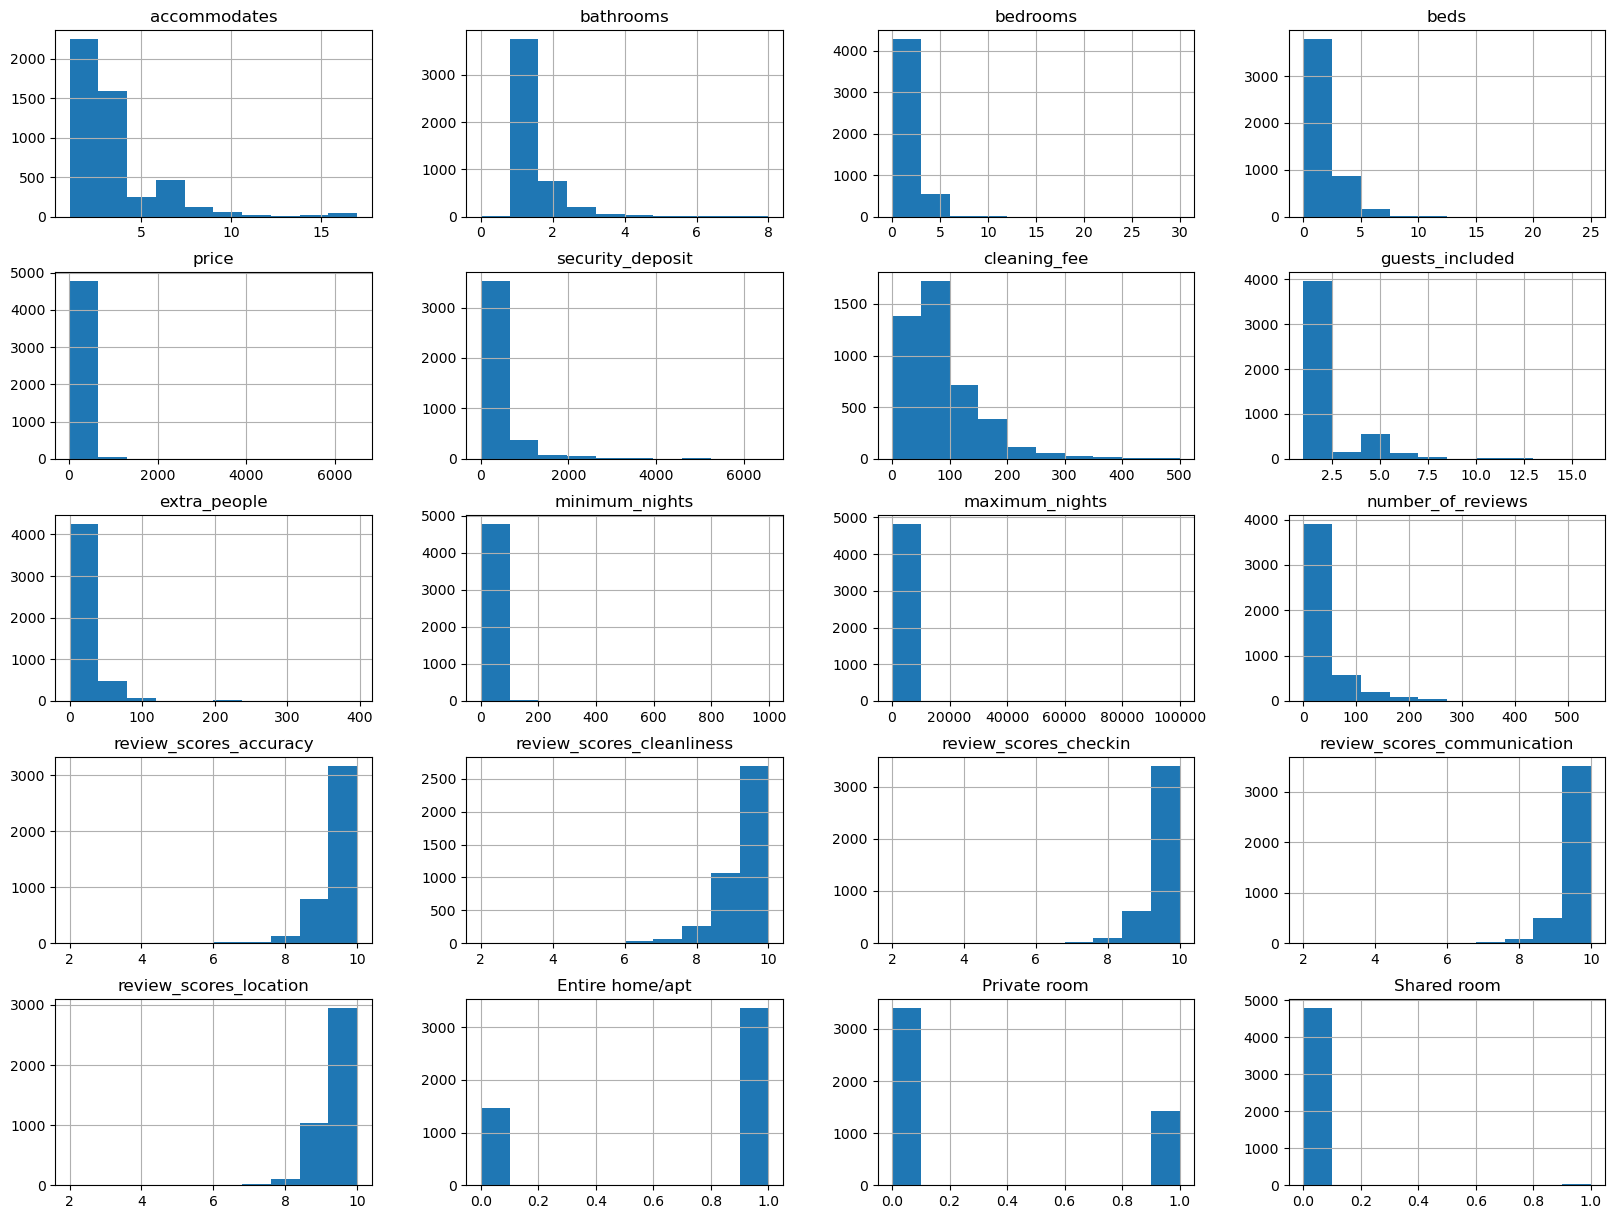

In [20]:
# Histograma de las variables
df.drop(columns=['latitude', 'longitude']).hist(figsize=(20,15))
plt.show()

Podemos observar una gran asimetría por la derecha en las variables. Por tanto, tras realizar la imputación de missings y el estudio de los outliers, se estudiará el coeficiente de asimetría realizando las trasnformaciones necesarias.

## 1.3 Imputación de missings

In [21]:
# Valores missing
df.isnull().sum()

latitude                         0
longitude                        0
accommodates                     0
bathrooms                        0
bedrooms                         2
beds                             6
price                            0
security_deposit               785
cleaning_fee                   414
guests_included                  0
extra_people                     0
minimum_nights                   0
maximum_nights                   0
number_of_reviews                0
review_scores_accuracy         706
review_scores_cleanliness      705
review_scores_checkin          708
review_scores_communication    707
review_scores_location         708
Entire home/apt                  0
Private room                     0
Shared room                      0
dtype: int64

### 1.3.1 Variables 'bedrooms' y 'beds'

Para imputar los missing de las variables *bedrooms* y *beds* empleamos un modelo de regresión lineal donde las variables regresoras son *accommodates* y *bathrooms*.

In [22]:
# Librerias
from sklearn.linear_model import LinearRegression

En primer lugar, imputamos la variable **_bedrooms_**

In [23]:
# Separacion de variables
target = 'bedrooms'
regresoras = ['accommodates', 'bathrooms']

# Dataframe con las variables seleccionadas
df_imp = df[[target] + regresoras]

# Division de los datos en dos dataframe, uno con los valores missing y otro sin valores missing
df_missing = df_imp[df_imp.isnull().any(axis=1)]
df_no_missing = df_imp.dropna()

# Ajuste del modelo de los datos sin missing
reg = LinearRegression()
reg.fit(df_no_missing[regresoras], df_no_missing[target])

# Imputacion de los valores missing y almacenamiento de los valores obtenidos en el dataframe 
pred = reg.predict(df_missing[regresoras])
df.loc[df[target].isnull(), target]= pred

Imputamos los missing en la variable **_beds_**

In [24]:
# Separacion de variables
target = 'beds'
regresoras = ['accommodates', 'bathrooms']

# Dataframe con las variables seleccionadas
df_imp = df[[target] + regresoras]

# Division de los datos en dos dataframe, uno con los valores missing y otro sin valores missing
df_missing = df_imp[df_imp.isnull().any(axis=1)]
df_no_missing = df_imp.dropna()

# Ajuste del modelo de los datos sin missing
reg = LinearRegression()
reg.fit(df_no_missing[regresoras], df_no_missing[target])

# Imputacion de los valores missing y almacenamiento de los valores obtenidos en el dataframe 
pred = reg.predict(df_missing[regresoras])
df.loc[df[target].isnull(), target]= pred

### 1.3.2 Variables 'security_deposit' y 'cleaning_fee '

Consideramos que los valores NaN son 0, es decir, tendrían sentido y sería que no se paga depósito ni tasas de limpieza. 

In [25]:
# Imputacion de los valores missing
df['security_deposit'] = df['security_deposit'].replace(np.nan, 0)
df['cleaning_fee'] = df['cleaning_fee'].replace(np.nan, 0)

### 1.3.3 Variables tipo 'review_scores_'

In [26]:
# Comprobacion de los valores missing
review_score = ['review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication','review_scores_location']

df[df[review_score].isna().any(axis=1)][review_score]

,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location
id,,,,,
48146,NaN,NaN,NaN,NaN,NaN
1126273,NaN,NaN,NaN,NaN,NaN
1229714,NaN,NaN,NaN,NaN,NaN
1620084,NaN,NaN,NaN,NaN,NaN
1660055,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
32135798,NaN,NaN,NaN,NaN,NaN
32151243,NaN,NaN,NaN,NaN,NaN
32152929,NaN,NaN,NaN,NaN,NaN


Así, decidimos eliminar las observaciones

In [27]:
# Eliminacion de las observaciones
df = df.dropna(subset=review_score)

## 1.4 Outliers

En primer lugar, se muestra los boxplot de cada una de las variables.

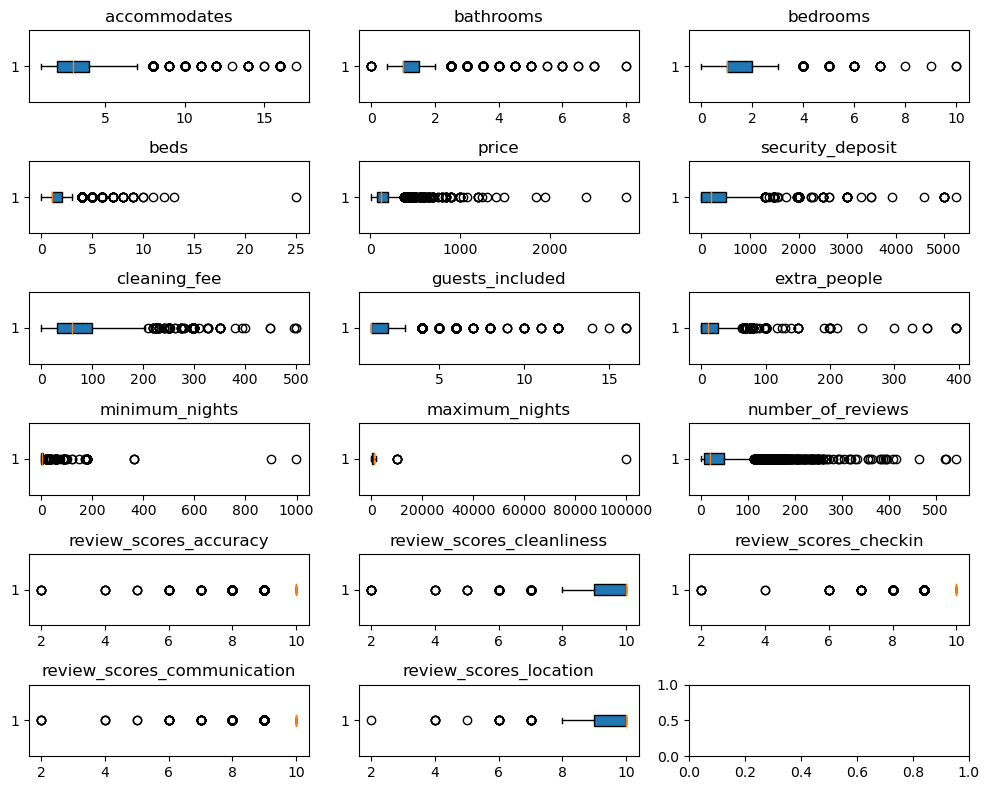

In [28]:
# Numero de filas y columnas necesarias para dibujar todos los boxplots
n_rows = 6
n_cols = 3
columnas = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin','review_scores_communication', 'review_scores_location']

# Matriz de subgraficos
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 8))

# Boxplot de cada variable
for i, columna in enumerate(columnas):
    ax = axs[i // n_cols][i % n_cols]
    ax.boxplot(df[columna],vert=False,patch_artist=True) # boxplot de la variable
    ax.set_title(columna)

# Ajuste de espacios entre subgraficos
fig.tight_layout()

# Mostrar la figura
plt.show()

Estudiamos los outliers en conjunto con aquellas variables con las que podrían tener más relación. La relación entre las variables podemos estudiarla mediante la matriz de correlaciones

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,maximum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,Entire home/apt,Private room,Shared room
latitude,1.000000,-0.091854,-0.068062,-0.049372,-0.142906,-0.094101,0.099694,0.132790,0.161202,-0.061709,...,0.007066,0.079285,0.033667,0.017332,-0.050066,0.038948,0.200373,0.266724,-0.277306,0.044477
longitude,-0.091854,1.000000,-0.041075,-0.084609,-0.026113,-0.026044,-0.167960,-0.049751,-0.126247,-0.014581,...,-0.014911,0.056384,0.022181,0.037941,0.024320,0.016107,-0.280161,-0.054484,0.047656,0.037587
accommodates,-0.068062,-0.041075,1.000000,0.552023,0.811762,0.838057,0.561351,0.249254,0.522610,0.599453,...,0.015292,-0.050108,-0.070669,-0.026944,-0.029805,-0.020643,0.041347,0.416291,-0.408394,-0.057324
bathrooms,-0.049372,-0.084609,0.552023,1.000000,0.629066,0.518669,0.502955,0.270065,0.461937,0.355594,...,0.003912,-0.119025,-0.075141,-0.052964,-0.036348,-0.031953,0.036811,0.122795,-0.131523,0.040499
bedrooms,-0.142906,-0.026113,0.811762,0.629066,1.000000,0.771466,0.553984,0.246299,0.504547,0.539339,...,-0.007094,-0.105486,-0.056281,-0.029619,0.005700,-0.001051,0.021775,0.275592,-0.269652,-0.041650
beds,-0.094101,-0.026044,0.838057,0.518669,0.771466,1.000000,0.508499,0.226118,0.476772,0.546593,...,0.004149,-0.059888,-0.048341,-0.015203,0.007682,0.001354,0.020159,0.337740,-0.336822,-0.018017
price,0.099694,-0.167960,0.561351,0.502955,0.553984,0.508499,1.000000,0.292320,0.525051,0.390711,...,0.003870,-0.104884,0.012297,0.026779,-0.015980,0.026476,0.113195,0.351476,-0.345494,-0.044847
security_deposit,0.132790,-0.049751,0.249254,0.270065,0.246299,0.226118,0.292320,1.000000,0.405083,0.194235,...,0.044567,-0.049730,0.004476,0.044670,-0.017904,-0.007123,0.047932,0.231378,-0.226464,-0.034591
cleaning_fee,0.161202,-0.126247,0.522610,0.461937,0.504547,0.476772,0.525051,0.405083,1.000000,0.368321,...,0.021604,-0.126151,-0.017357,0.041147,-0.023045,0.002189,0.104090,0.431257,-0.422422,-0.062785
guests_included,-0.061709,-0.014581,0.599453,0.355594,0.539339,0.546593,0.390711,0.194235,0.368321,1.000000,...,0.008247,0.006298,-0.017860,0.015701,0.018058,0.015537,0.017516,0.269419,-0.263623,-0.040658


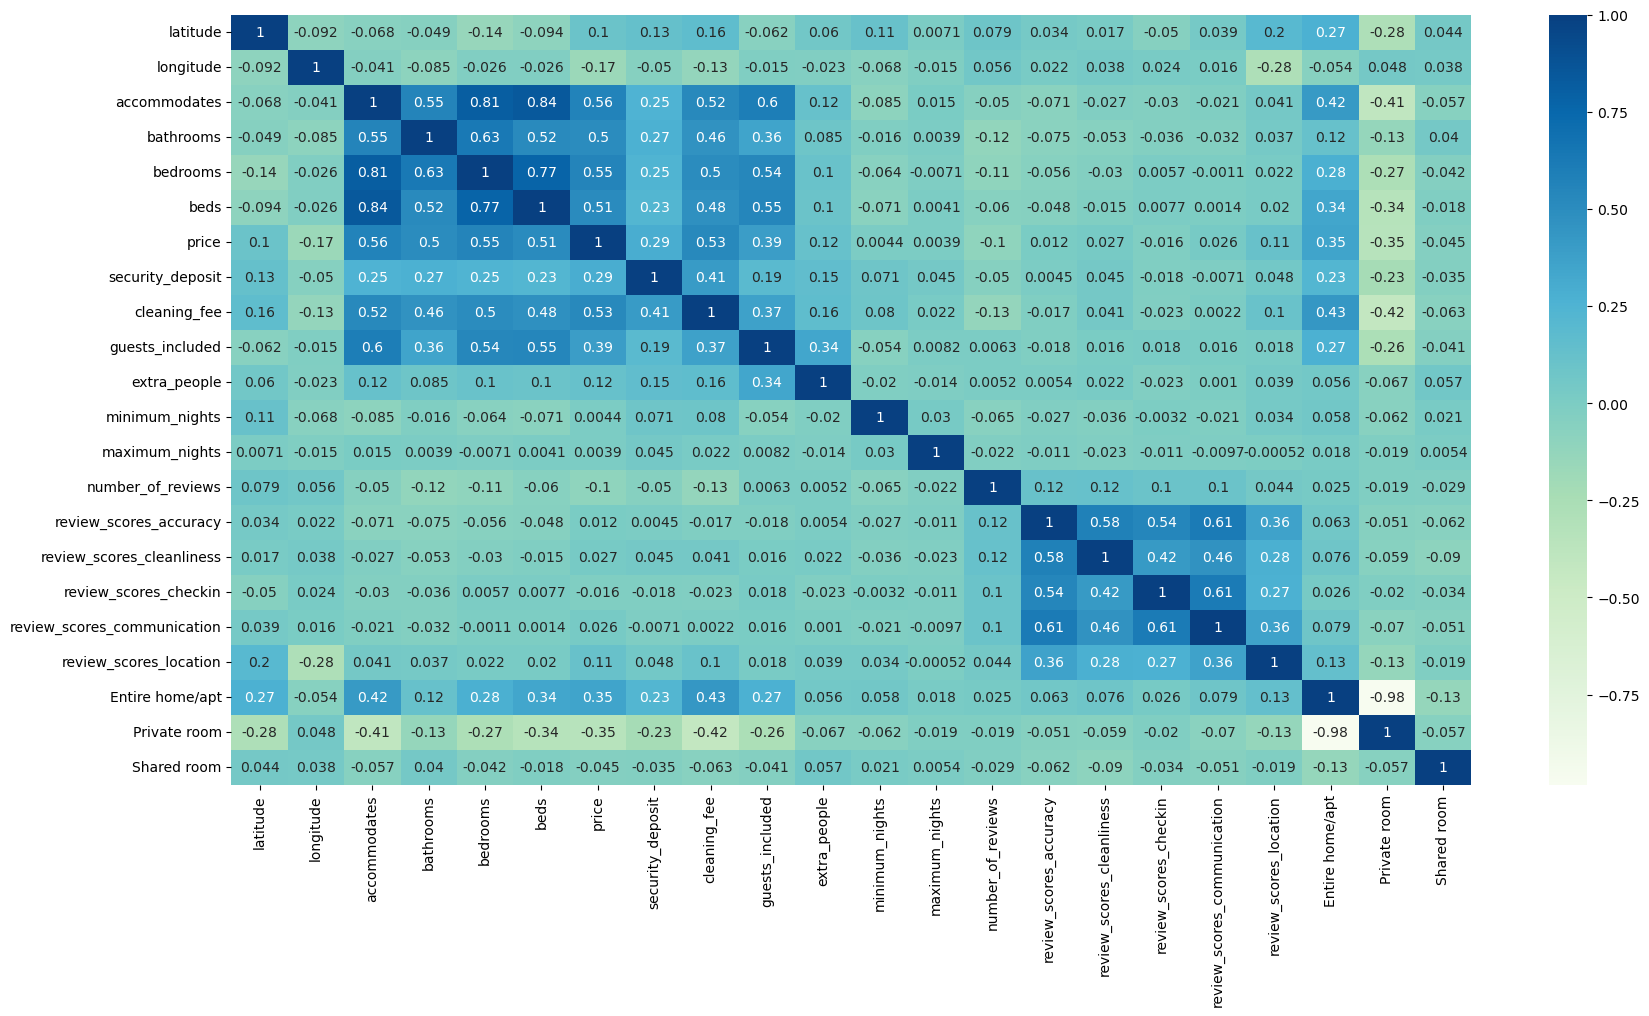

In [29]:
# Correlaciones
plt.figure(figsize=(20,10))
correlaciones= df.corr()
sns.heatmap(correlaciones,cmap="GnBu",annot=True) 
correlaciones

Dividimos las variables en distintos grupos en función de su correlación para analizarlas conjuntamente.

### 1.4.1 Variables relacionadas con la disposición del alojamiento

**Accommodate, bathrooms,  bedrooms, beds**

Primero vamos a estudiar los outliers en las variables relativas a la disposicion del alojamiento

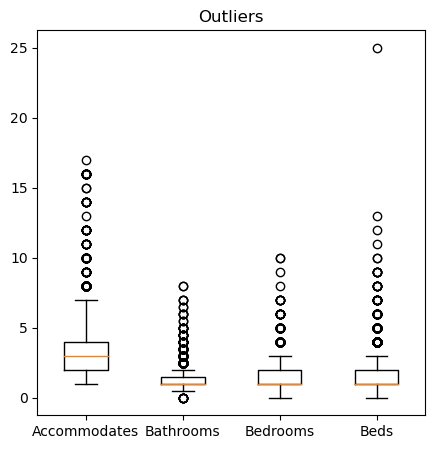

In [30]:
# Boxplot de las habitaciones
fig = plt.figure(figsize = (5,5))

plt.boxplot(df[['accommodates', 'bathrooms','bedrooms', 'beds']])

plt.title('Outliers')
plt.xticks([1,2,3,4], ['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds'])

plt.show()

Estudiamos los outliers en conjunto. Para ello empleamos la librería *PyOD* que posee estrategias para detectar outliers. En este caso, empleamos el algoritmo de KNN

In [31]:
# !pip install pyod

In [32]:
# Librerias
from pyod.models.knn import KNN

In [33]:
# Deteccion de outliers
A = df[['accommodates','bathrooms','bedrooms', 'beds', 'Entire home/apt', 'Private room']]
clf = KNN(contamination=0.01)
clf.fit(A)

# Outliers
y_pred = clf.predict(A)
outliers = A[y_pred == 1]

# Tipo de alojamiento
indices = outliers.index
outliers['property_type'] = df_original.loc[indices,:]['property_type']
outliers

,accommodates,bathrooms,bedrooms,beds,Entire home/apt,Private room,property_type
id,,,,,,,
1096393,10.0,1.0,10.0,1.0,1,0,Apartment
6830599,16.0,3.0,4.0,7.0,1,0,Villa
15735770,14.0,3.0,5.0,10.0,1,0,House
15987030,1.0,8.0,1.0,1.0,0,1,Apartment
16606630,13.0,1.0,3.0,3.0,1,0,Apartment
16689567,10.0,3.0,5.0,9.0,1,0,House
17347671,14.0,2.5,3.0,7.0,1,0,Townhouse
17848238,10.0,2.0,2.0,2.0,1,0,House
19589647,17.0,3.5,5.0,25.0,1,0,House


Podríamos considerar outliers los que se trata de un apartamento, dado que por lo general, el número de posibles huéspedes es muy alto y las dimensiones de un apartamento no suelen ser tan grandes.

In [34]:
# Comprobacion outliers
outliers[outliers['property_type']=='Apartment']

,accommodates,bathrooms,bedrooms,beds,Entire home/apt,Private room,property_type
id,,,,,,,
1096393,10.0,1.0,10.0,1.0,1,0,Apartment
15987030,1.0,8.0,1.0,1.0,0,1,Apartment
16606630,13.0,1.0,3.0,3.0,1,0,Apartment


Así, podemos observar que parece que se trata de datos mal registrados.

- En el primer caso, parece que se trata de un apartamente con 10 habitaciones y (posiblemente 1 cama por habitación).
- En el segundo caso, parece que se trata de una habitación privada en un apartamento.
- En el tercer caso

Decidimos eliminar las observaciones.

In [35]:
# Eliminacion de las observaciones correspondientes con apartamentos
indices_apt = outliers[outliers['property_type']=='Apartment'].index
df.drop(indices_apt, inplace = True)

### 1.4.2 Variables relacionadas con tasas extra

**Security deposit, cleaning fee, guests included, extra people**

**Security deposit**

Vemos cómo se distribuye la variable y sus posibles outliers

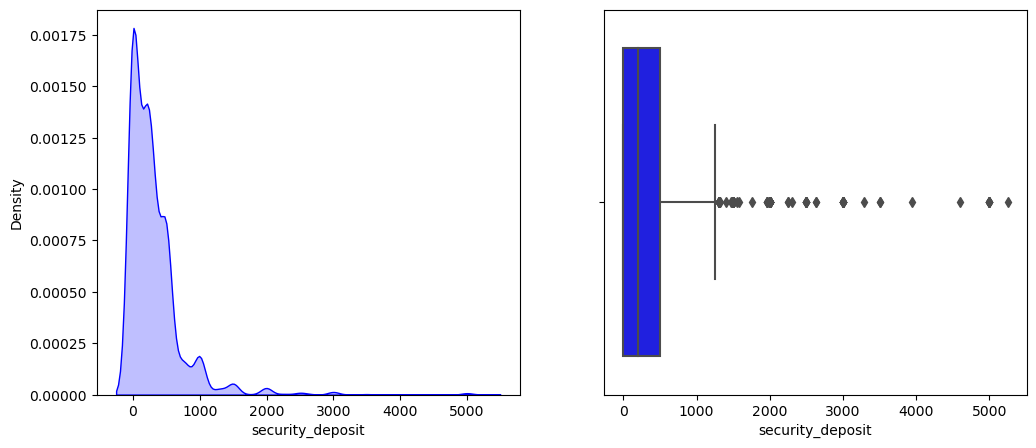

In [36]:
# Distribucion y boxplot de security deposit
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df['security_deposit'], shade=True, color='blue',ax=axes[0])
sns.boxplot(df['security_deposit'], color='blue', ax=axes[1])

plt.show()

In [37]:
# Cuantiles de la variable
df['security_deposit'].quantile([0.25,0.5, 0.75, 0.95, 0.99])

0.25       0.0
0.50     200.0
0.75     500.0
0.95    1000.0
0.99    2000.0
Name: security_deposit, dtype: float64

Las fianzas altas suelen estar relacionadas con largas estancias o con lugares de grandes dimensiones. Denominamos fianza alta a aquellas por encima del cuantil 0,95.

In [38]:
# Dataframe con fianzas por encima del cualtil 95
q95 = df['security_deposit'].quantile(0.95) 
df_fianza = df[df['security_deposit']>=q95][['minimum_nights','maximum_nights', 
                                             'price','security_deposit','Entire home/apt', 'Private room', 'Shared room']]
indices = df_fianza.index
df_fianza['property_type'] = df_original.loc[indices]['property_type']
df_fianza

,minimum_nights,maximum_nights,price,security_deposit,Entire home/apt,Private room,Shared room,property_type
id,,,,,,,,
14508,90,365,140.0,1000.0,1,0,0,Apartment
26047,30,365,159.0,1000.0,1,0,0,Apartment
26234,30,730,169.0,1000.0,1,0,0,Apartment
42645,30,730,159.0,1000.0,1,0,0,Condominium
54261,90,365,98.0,1500.0,1,0,0,Condominium
...,...,...,...,...,...,...,...,...
30914254,2,200,98.0,2500.0,1,0,0,Apartment
31044697,2,1125,600.0,1000.0,1,0,0,Apartment
31212290,2,27,1488.0,1000.0,1,0,0,House


Podríamos considerar outliers aquellos que no sean larga estancia y/o no correspondan con un alojamiento de grandes dimensiones.

In [39]:
# Tipos de alojamiento
df_fianza['property_type'].value_counts()

House                 95
Condominium           78
Apartment             54
Loft                  16
Serviced apartment    11
Townhouse             10
Guest suite            8
Guesthouse             3
Villa                  3
Other                  2
Camper/RV              1
Name: property_type, dtype: int64

In [40]:
# Dataframe con estancias de menos de 4 meses y tipo de alojamiento pequeño
df_fianza[(df_fianza['maximum_nights']<(30*4)) & 
          ((df_fianza['property_type']=='Apartment') | (df_fianza['property_type']=='Loft') | (df_fianza['property_type']=='Other'))]

,minimum_nights,maximum_nights,price,security_deposit,Entire home/apt,Private room,Shared room,property_type
id,,,,,,,,
1678196,2,60,150.0,1000.0,1,0,0,Apartment
1764095,30,90,171.0,1575.0,1,0,0,Apartment
3448674,2,21,199.0,1500.0,1,0,0,Loft
6975300,10,89,249.0,1999.0,1,0,0,Loft
7162553,7,30,196.0,1000.0,1,0,0,Loft
8868498,1,27,150.0,1000.0,1,0,0,Other
10837935,1,30,282.0,1500.0,1,0,0,Loft
12052091,61,90,91.0,1400.0,1,0,0,Apartment
19118514,2,90,320.0,1200.0,1,0,0,Apartment


Este dataframe muestra aquellas observaciones que no corresponden a largas estancias (menos de 4 meses) y además el alojamiento es "pequeño" (apartamento, loft y otros). Consideramos que son outliers y los eliminamos.

In [41]:
# Eliminacion de las observaciones que no son largas estancias o grandes alojamientos
indices_est = df_fianza[(df_fianza['maximum_nights']<(30*4)) & 
                        ((df_fianza['property_type']=='Apartment') | (df_fianza['property_type']=='Loft') | (df_fianza['property_type']=='Other'))].index
df.drop(indices_est, inplace = True)

**Cleaning fee**

Vemos la distribución de _cleaning_fee_ y sus posibles valores atípicos

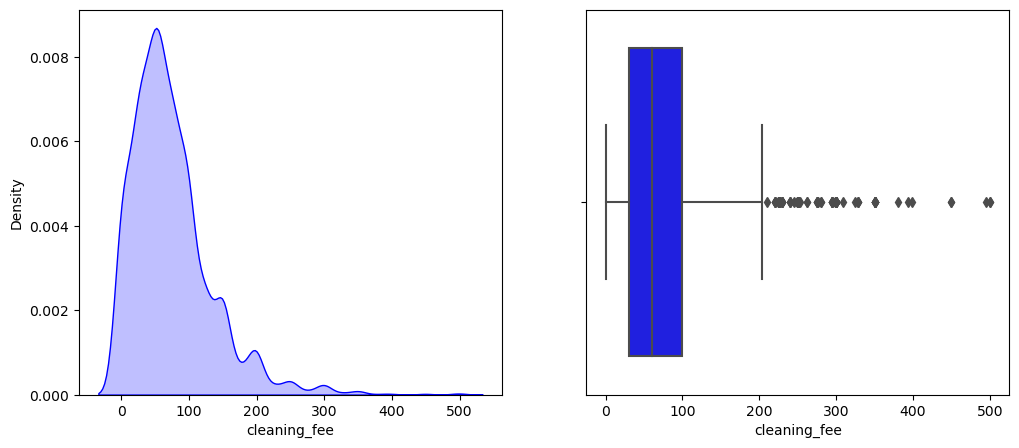

In [42]:
# Distribucion y boxplot de cleaning fee
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df['cleaning_fee'], shade=True, color='blue',ax=axes[0])
sns.boxplot(df['cleaning_fee'], color='blue', ax=axes[1])

plt.show()

Representamos las tasas de limpieza para los distintos tipos de alojamiento.

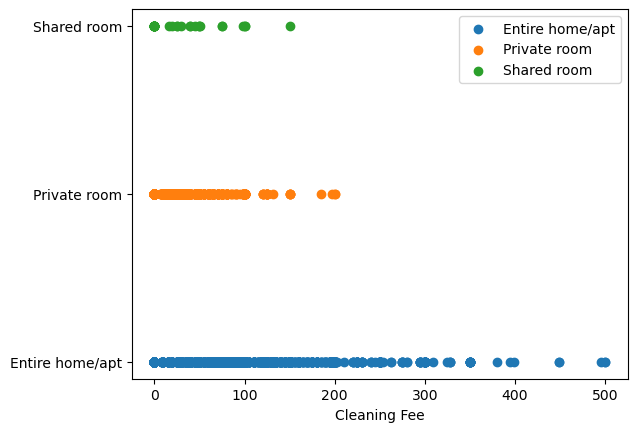

In [43]:
# Crear la figura y los ejes
fig, axs = plt.subplots()

# Tramar el gráfico de dispersión con diferentes categorías
axs.scatter(df[df['Entire home/apt'] == 1]['cleaning_fee'], [1] * len(df[df['Entire home/apt'] == 1]), label='Entire home/apt')
axs.scatter(df[df['Private room'] == 1]['cleaning_fee'], [2] * len(df[df['Private room'] == 1]), label='Private room')
axs.scatter(df[df['Shared room'] == 1]['cleaning_fee'], [3] * len(df[df['Shared room'] == 1]), label='Shared room')

# Añadir etiquetas a los ejes
axs.set_xlabel('Cleaning Fee')
axs.set_yticks([1, 2, 3])
axs.set_yticklabels(['Entire home/apt', 'Private room', 'Shared room'])

# Mostrar la leyenda
axs.legend()

# Mostrar el gráfico
plt.show()

Estudiamos la relación entre 'cleaning_fee' y 'review_scores_cleanliness'.

Text(0, 0.5, 'Review Scores Cleanliness')

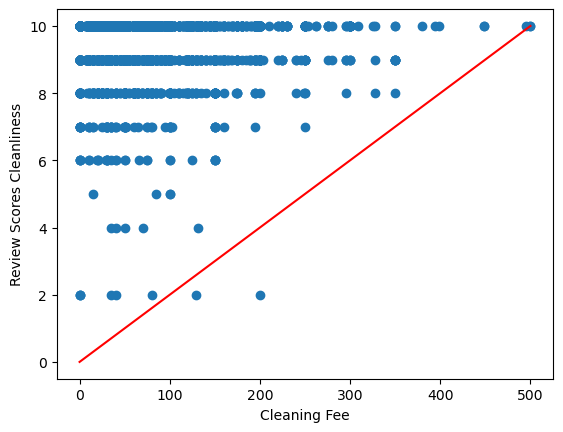

In [44]:
# Relacion cleaning_fee y review_score_cleanliness
plt.scatter(df['cleaning_fee'],df['review_scores_cleanliness'])
plt.plot( [0, 500],  [0, 10] , color='red')
plt.xlabel('Cleaning Fee')
plt.ylabel('Review Scores Cleanliness')

Consideramos que todos los datos que estén por debajo de la línea son outliers. Decidimos eliminarlos.

In [45]:
# Eliminacion de las observaciones
indices = df[(df['cleaning_fee']>100)&(df['review_scores_cleanliness']<3)].index
df.drop(indices, inplace=True)

**Guests included**

Podemos estudiar esta variable en conjunto de con número de huéspedes y el número de camas/habitaciones

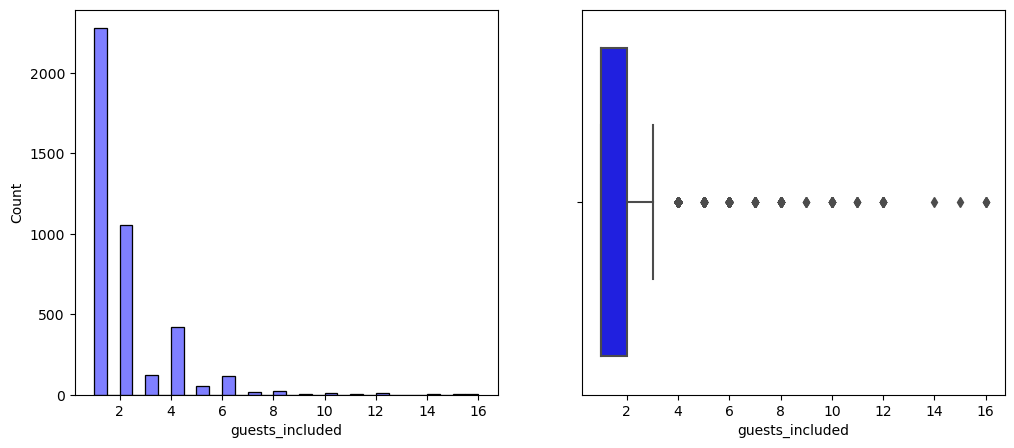

In [46]:
# Distribucion y boxplot de guests_included
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['guests_included'], bins=30, alpha=0.5, color='blue', ax=axes[0])
sns.boxplot(df['guests_included'], color='blue', ax=axes[1])

plt.show()

Consideramos outliers aquellos donde los invitados son más del doble de los posibles huéspedes.

In [47]:
# Dataframe con posibles valores atipicos de guests_included
outliers_guests = df[df['guests_included']>2*df['accommodates']][['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
                                               'guests_included', 'Entire home/apt', 'Private room']]
outliers_guests

,accommodates,bathrooms,bedrooms,beds,price,guests_included,Entire home/apt,Private room
id,,,,,,,,
1032892,2.0,1.0,1.0,1.0,94.0,15,0,1
17844795,2.0,1.0,1.0,1.0,199.0,6,0,1
21968371,2.0,1.0,1.0,1.0,39.0,10,0,1
23810907,2.0,1.0,1.0,1.0,98.0,10,0,1


Decidimos eliminar las observaciones

In [48]:
# Eliminacion de las observaciones
df.drop(outliers_guests.index, inplace=True)

**Extra people**

Podemos estudiar esta variable en conjunto con el tipo de alojamiento y 'guests_included'. En primer lugar, observamos su distribución y los posibles valores atípicos.

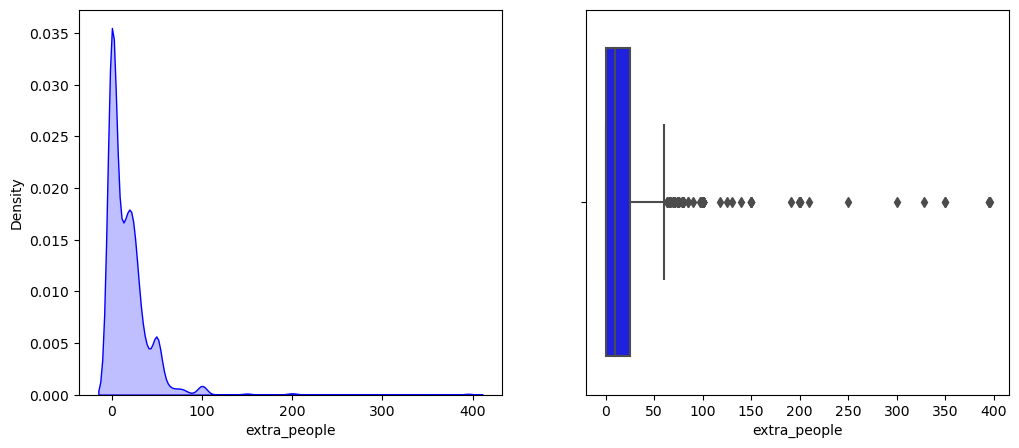

In [49]:
# Distribucion y boxplot de extra_people
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df['extra_people'], shade=True, color='blue',ax=axes[0])
sns.boxplot(df['extra_people'], color='blue', ax=axes[1])

plt.show()

In [50]:
# Cuantiles de la variable
df['extra_people'].quantile([0.25,0.5, 0.75, 0.95, 0.99])

0.25      0.0
0.50     10.0
0.75     25.0
0.95     50.0
0.99    100.0
Name: extra_people, dtype: float64

Consideramos posibles outliers aquellos por encima del cuantil 0,95 (ó del cuantil 0,99)

In [51]:
# Dataframe con posibles outliers de extra_people
q99 = df['extra_people'].quantile(0.99)
outliers_extra = df[df['extra_people']>q99][['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included', 'extra_people', 
                            'Entire home/apt', 'Private room', 'Shared room']]
outliers_extra

,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,Entire home/apt,Private room,Shared room
id,,,,,,,,,,
2460888,2.0,1.0,1.0,1.0,197.0,2,328.0,1,0,0
2675179,4.0,2.0,2.0,2.0,450.0,4,350.0,1,0,0
2703279,6.0,2.0,3.0,4.0,500.0,6,395.0,1,0,0
5538655,4.0,1.0,2.0,2.0,81.0,4,200.0,1,0,0
6249125,4.0,1.0,1.0,2.0,249.0,2,191.0,1,0,0
12603779,2.0,1.0,1.0,1.0,100.0,2,395.0,1,0,0
13291492,2.0,1.0,1.0,1.0,199.0,2,199.0,1,0,0
13620049,3.0,2.0,2.0,2.0,350.0,3,250.0,1,0,0
14074129,2.0,1.0,1.0,2.0,98.0,2,118.0,1,0,0


No consideramos que las osbervaciones sean outliers.

### 1.4.3 Variables relacionadas las reseñas

Las reseñas son muy subjetivas y pueden presentar mucha variabilidad. Por ejemplo, puede darse el caso de un alojamiento situao en una muy buena ubicación pero con pésimas condiciones de limpieza. 

**Variables de tipo review_score_**

Calculamos la puntuación media según el tipo de habitación

In [52]:
# Dataframe con las variables review
reviews = df[['number_of_reviews','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
              'review_scores_communication', 'review_scores_location']]

indices_reviews = reviews.index
reviews['room_type'] = df_original.loc[indices_reviews,:]['room_type']

# Valoraciones media segun el tipo de habitacion    
df_media = reviews.groupby(['room_type']).mean()
df_media.drop('number_of_reviews', axis=1, inplace=True)

<Figure size 1200x500 with 0 Axes>

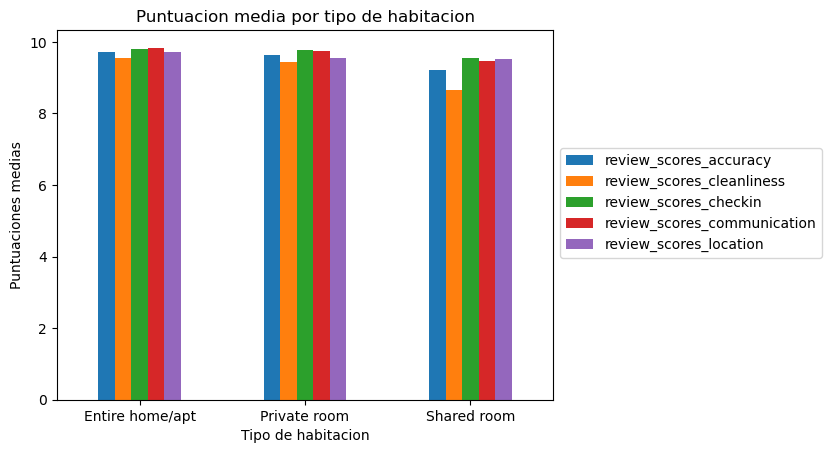

In [53]:
# Grafico puntuaciones medias
plt.figure(figsize=(12, 5))

df_media.plot(kind='bar', ylabel='Puntuaciones medias',xlabel='Tipo de habitacion',title='Puntuacion media por tipo de habitacion')
plt.legend(bbox_to_anchor=(1, 0, 0, 0.7));plt.xticks(rotation=0)

plt.show()

**Otra idea**: Intentar mirar reviews por zonas con latitude y longitude

### 1.4.4 Variables relacionadas con las noches

**minimum**

En primer lugar, sacamos los estadísticos de esta variable

In [54]:
# Estadisticos descriptivos
df['minimum_nights'].describe()

count    4108.000000
mean       10.824732
std        29.244450
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max       998.000000
Name: minimum_nights, dtype: float64

También podemos ver que existen algunos casos extraños donde la duración de la estancia es muy particular 

In [55]:
# Intervalos de un dia entre min y max
df[df['maximum_nights']-df['minimum_nights']<2][['minimum_nights', 'maximum_nights']]

,minimum_nights,maximum_nights
id,,
11400,364,364
13357,30,30
1191143,3,3
7787575,98,99
11102652,365,365
11949456,2,3
12434489,1,1
13771205,998,999
13817015,30,30


Decidimos borrar de estos últimos aquellos que no corresponden con 30 días o múltiplos del mismo.

In [56]:
# Indices de las observaciones que se van a eliminar
outliers_min = df[df['maximum_nights']-df['minimum_nights']<2][['minimum_nights', 'maximum_nights']]
indices_min = [1191143, 7787575, 11949456, 12434489, 13771205, 15819364, 15840160,
17438123, 18638835, 19101912, 25011581, 25750741, 25887824, 26424386,
28765752]

# Eliminacion de las observaciones
df.drop(indices_min, inplace = True)

Procedemos a estudiar el resto de los casos. 

Observamos la distribución del número mínimo de noches

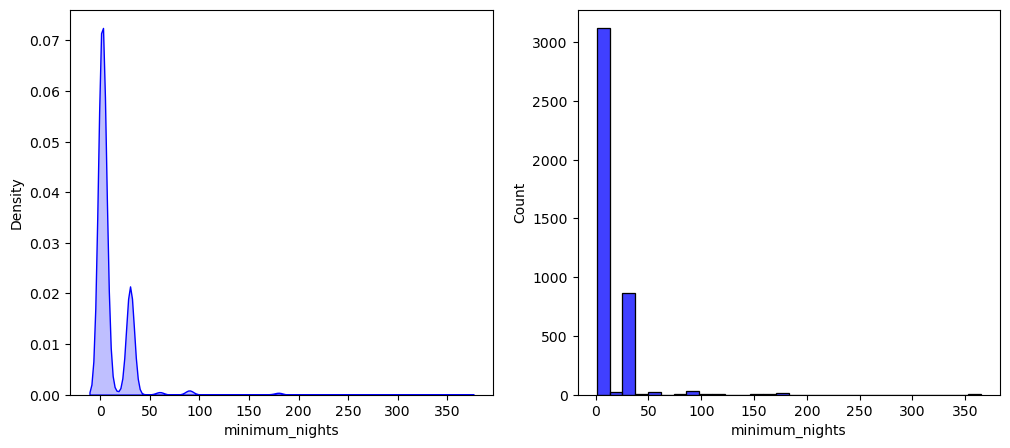

In [57]:
# Distribucion y boxplot de minimum_nights
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df['minimum_nights'], shade=True, color='blue', ax=axes[0])
sns.histplot(df['minimum_nights'], color='blue', bins = 30, ax=axes[1])

plt.show()

Hay dos picos, uno para alquileres por noche (min 1 noche) y otro para alquieres por meses (min 30 noche). 

Se considera que pueden existir alquileres que exijan ciertos meses de permanencia. Por tanto, no se considera outlier ninguno de los anteriores casos

**maximum**

Estudiamos nuevamente los estadísticos de la variable

In [58]:
# Estadisticos descriptivos
df['maximum_nights'].describe()

count     4093.000000
mean       704.029807
std       1668.408412
min          3.000000
25%         52.000000
50%       1125.000000
75%       1125.000000
max      99999.000000
Name: maximum_nights, dtype: float64

Se puede observar que hay muchas observaciones concentradas en el valor 1125 (posiblemente sea un valor por defecto).
Por tanto, imputamos este valor como cota máxima del número máximo de noches.

In [59]:
# Imputacion de cota maxima
df.loc[df['maximum_nights'] > 1125, 'maximum_nights'] = 1125

Procedemos a estudiar la distribución del número máximo de noches.

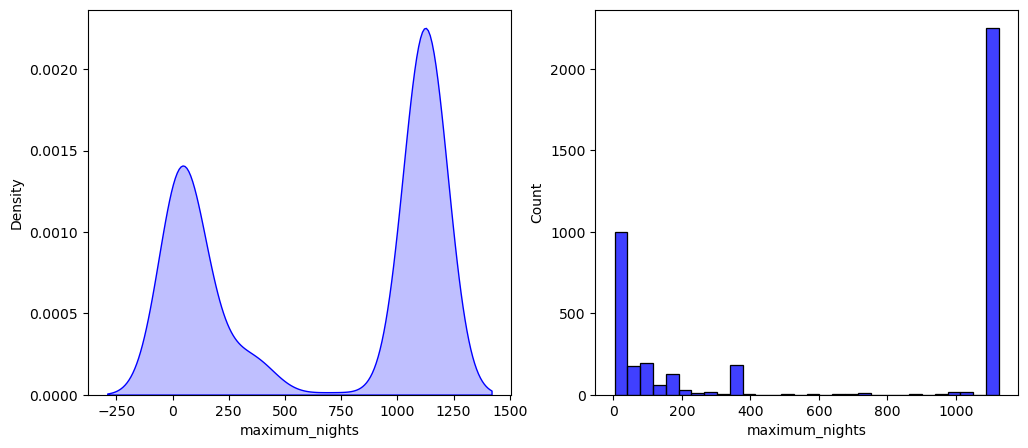

In [60]:
# Distribucion de maximum_nights
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df['maximum_nights'], shade=True, color='blue', ax=axes[0])
sns.histplot(df['maximum_nights'], color='blue', bins = 30, ax=axes[1])

plt.show()

Nuevamente vemos como existen 2 picos. El primero que hace referencia a estancias de corta duración y otro que hace referencia estancias de larga duracion.

## 1. 5 Transformaciones 

Como habíamos comentado, las variables presentan asimetría, lo cual no es favorable para los modelos de regresión. Podemos estudiar esto mediante el coeficiente de asimetria de Fisher, que mida la centralidad de los datos. Si el coeficiente es 0, los datos están centrados entrorno a la media, si es postivo presentan asimetría por la derecha, y si es negativo asimetría por la izquierda.

In [61]:
# Simetria
df.skew(axis=0)

latitude                       -0.793538
longitude                      -0.023926
accommodates                    2.161514
bathrooms                       3.204828
bedrooms                        1.915946
beds                            3.351313
price                           5.414590
security_deposit                4.479302
cleaning_fee                    1.705605
guests_included                 2.841924
extra_people                    5.938725
minimum_nights                  6.851736
maximum_nights                 -0.293540
number_of_reviews               3.099863
review_scores_accuracy         -3.814141
review_scores_cleanliness      -2.898199
review_scores_checkin          -4.588931
review_scores_communication    -5.163529
review_scores_location         -2.902228
Entire home/apt                -0.870527
Private room                    0.910270
Shared room                    11.363738
dtype: float64

Así, aplicamos transformaciones logarísmicas a las variables continuas que no presentan simetría con sesgo positivo.

In [62]:
df_log = df.copy()

# Transformacion
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 
        'security_deposit','cleaning_fee', 'guests_included', 
        'extra_people','number_of_reviews']

for col in cols:
    df_log[col] = df_log[col].astype('float64').replace(0.0, 0.01)
    df_log[col] = np.log(df_log[col])

## 1.6 Análisis de correlaciones

Para finalizar, estudiamos las correlaciones entre las variables. Así, podemos decidir qué variables usar para el modelo y estudiar posibles relaciones existentes entre ellas.

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,maximum_nights,number_of_reviews,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,Entire home/apt,Private room,Shared room
latitude,1.000000,-0.091075,-0.021653,-0.009773,-0.122073,-0.068575,0.208993,0.125957,0.113179,-0.023639,...,-0.039598,0.068262,0.039334,0.020774,-0.049541,0.042834,0.201835,0.267739,-0.277968,0.043290
longitude,-0.091075,1.000000,-0.033259,-0.060077,-0.004744,-0.008516,-0.230727,-0.015991,-0.040805,-0.014152,...,-0.033767,0.062079,0.023086,0.041015,0.024773,0.016552,-0.277936,-0.053050,0.046170,0.038179
accommodates,-0.021653,-0.033259,1.000000,0.432268,0.399763,0.647452,0.645075,0.216345,0.264306,0.552794,...,0.027399,0.003628,-0.024840,0.004875,-0.002488,0.012305,0.057218,0.523266,-0.512446,-0.077142
bathrooms,-0.009773,-0.060077,0.432268,1.000000,0.311976,0.325169,0.425439,0.118171,0.150671,0.250076,...,0.010178,-0.098348,-0.054766,-0.036898,-0.030868,-0.019648,0.032292,0.143981,-0.152698,0.040161
bedrooms,-0.122073,-0.004744,0.399763,0.311976,1.000000,0.341001,0.268683,0.055502,0.057410,0.253900,...,-0.014274,-0.047950,-0.015826,-0.036513,0.022765,0.005165,0.025215,0.020208,-0.020329,-0.000149
beds,-0.068575,-0.008516,0.647452,0.325169,0.341001,1.000000,0.408312,0.129550,0.163593,0.399084,...,0.000281,-0.015476,-0.042757,-0.024976,0.009316,-0.003122,0.019079,0.307328,-0.306766,-0.014895
price,0.208993,-0.230727,0.645075,0.425439,0.268683,0.408312,1.000000,0.233418,0.251661,0.408882,...,0.020582,-0.061479,0.036385,0.074692,-0.009450,0.055333,0.175350,0.564515,-0.554010,-0.077087
security_deposit,0.125957,-0.015991,0.216345,0.118171,0.055502,0.129550,0.233418,1.000000,0.300268,0.216173,...,-0.008053,0.069358,0.013186,0.061928,-0.026827,0.010704,0.035457,0.256676,-0.250990,-0.039830
cleaning_fee,0.113179,-0.040805,0.264306,0.150671,0.057410,0.163593,0.251661,0.300268,1.000000,0.223027,...,0.016270,0.021585,-0.014143,0.045942,-0.027480,0.001032,0.033236,0.258598,-0.237739,-0.119547
guests_included,-0.023639,-0.014152,0.552794,0.250076,0.253900,0.399084,0.408882,0.216173,0.223027,1.000000,...,-0.001865,0.091006,-0.009690,0.032317,0.013592,0.016235,0.029366,0.328247,-0.321518,-0.048086


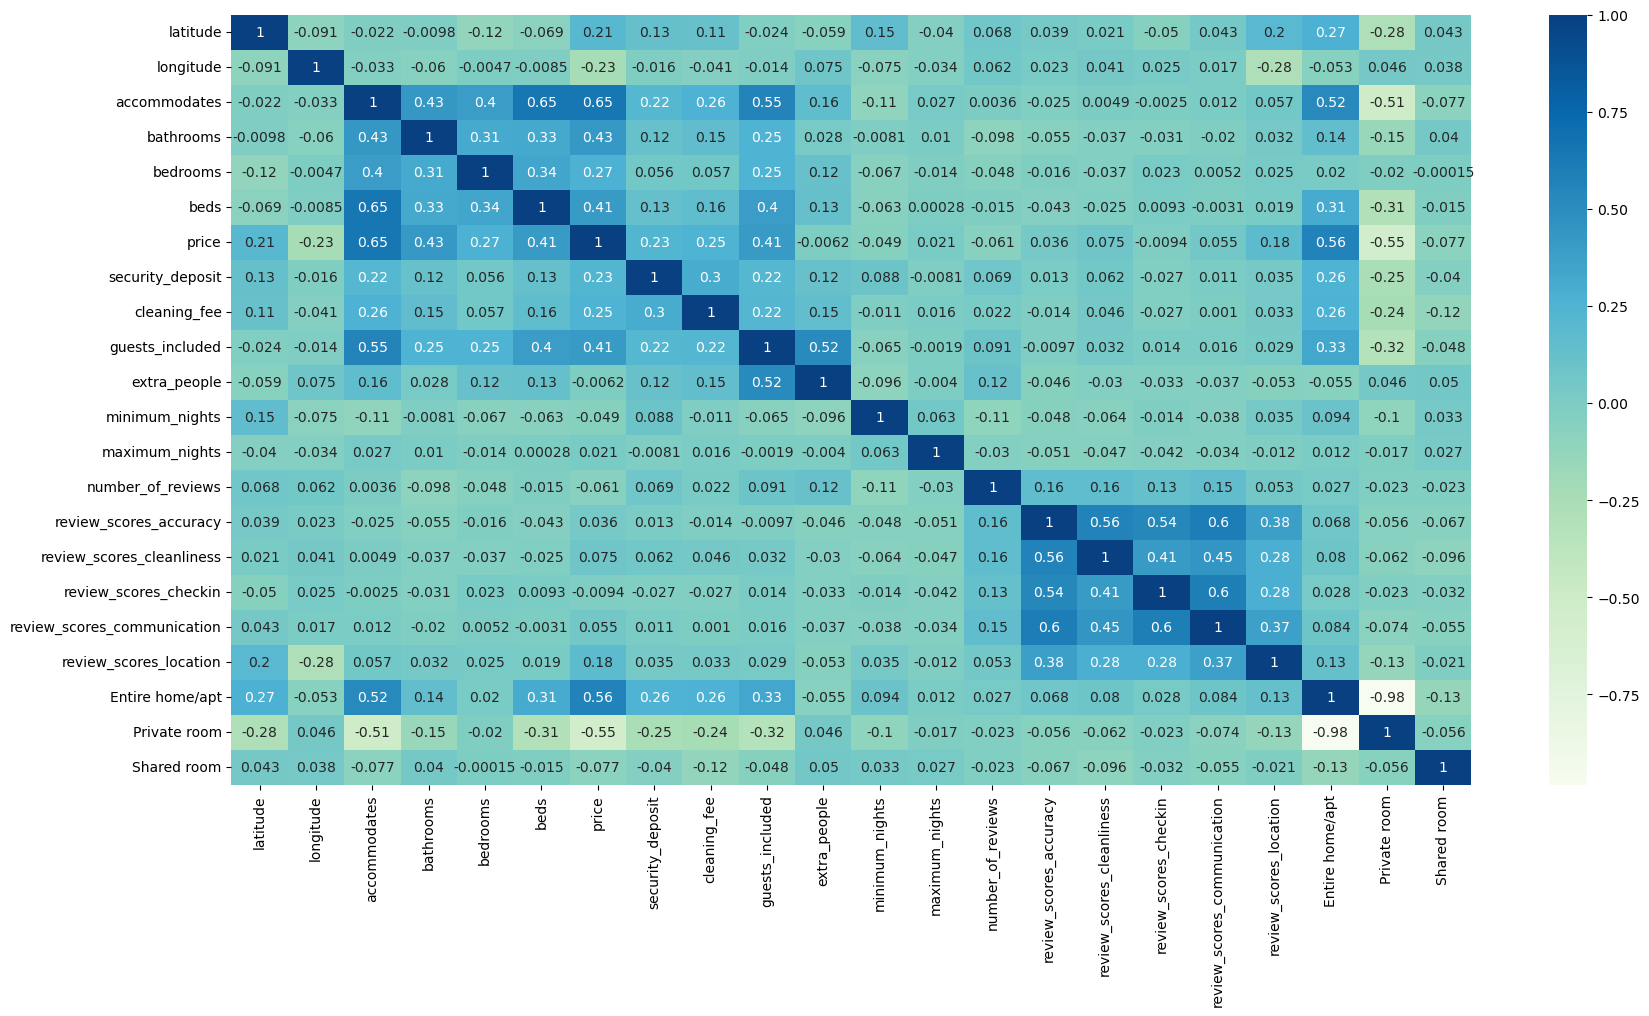

In [63]:
# Correlaciones
plt.figure(figsize=(20,10))
correlaciones= df_log.corr()
sns.heatmap(correlaciones,cmap="GnBu",annot=True) 
correlaciones

Así, seleccionamos las siguientes variables para el modelo:

Las variables de modelización:
* _latitude_
* _longitude_
* _bathrooms_
* _bedrooms_
* _security_deposit_
* _cleaning_fee_
* _number_of_reviews_ 
* _review_scores_accuracy_
* _Entire home/apt_
* _Private_room_
* _Shared_room_

Y la varibale de etiqueta:
* _price_

Creamos una nueva variable _review_ de la siguiente forma:

$$\text{review} = \text{review_scores_accuracy} \cdot 100\cdot \frac{\text{number_of_reviews}}{\sum \text{number_of_reviews}}$$

Esta sustituirá a las variables _number_of_reviews_ y _review_scores_accuracy_

In [64]:
# Nueva variable review
review = df['review_scores_accuracy']*(df['number_of_reviews']/sum(df['number_of_reviews'])*100)

Estudiamos la simetría de la variable mediante el coeficiente de Fisher y, en caso de que presente asimetría por la derecha, aplicamos una transformación logarítmica

In [65]:
# Coeficiente de asimetria y transformacion
print("Coeficiente de asimetría: " + str(review.skew()))
review = np.log(review)

Coeficiente de asimetría: 3.1453992010764096


Nos aseguramos de que la variable no contenga valores nulos (es decir, que anteriormente no haya tomado el valor 0.0 antes de aplicar la transformación)

In [66]:
# Valores nulos
review.isnull().sum()

0

# 2. División de los datos

In [67]:
# Librerias
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

En primer lugar, creamos la matriz de observaciones y el vector etiqueta con los que trabajaremos para ajustar el modelo de regresión lineal.

In [68]:
# Vector etiqueta
y = df_log['price']

# Matriz de observaciones
X = df_log[['latitude', 'longitude', 'accommodates', 'beds', 'security_deposit', 'cleaning_fee', 'extra_people',
            'Entire home/apt', 'Private room', 'Shared room']]
X.insert(7, 'review', review)

In [69]:
# Estandarizacion de los datos
objeto = StandardScaler()
X_ss = pd.DataFrame(objeto.fit_transform(X.iloc[:,0:8]), columns=list(X.iloc[:,0:8].columns))

# Concatenacion de los datos
X = pd.concat([X_ss, X.loc[:,'Entire home/apt':'Shared room'].reset_index()], axis=1)
X.drop('id', axis=1, inplace=True)
X.head(5)

,latitude,longitude,accommodates,beds,security_deposit,cleaning_fee,extra_people,review,Entire home/apt,Private room,Shared room
0,1.269929,-0.274755,1.261042,1.400105,-1.367867,0.735120,-1.133644,-0.080199,1,0,0
1,-0.404448,-0.061927,-1.967979,-0.657623,-1.367867,-3.064167,-1.133644,0.938500,0,1,0
2,-0.798196,0.127136,0.530333,0.371241,-1.367867,0.125844,-1.133644,1.603051,1,0,0
3,0.867194,0.119599,0.530333,0.371241,0.880640,0.739045,0.956087,0.703186,1,0,0
4,0.992544,-0.376765,-0.718823,-0.657623,0.688279,0.312578,-1.133644,2.186077,1,0,0


Separamos los datos en train y test

In [70]:
# Particion de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [71]:
# Librerias
import os

# Carpeta con datos
if not os.path.exists('Datos'):
    os.makedirs('Datos')
    
# Se guardan los datos
X_train.to_csv('Datos/X_train.csv', index=False)
X_test.to_csv('Datos/X_test.csv', index=False)
y_train.to_csv('Datos/y_train.csv', index=False)
y_test.to_csv('Datos/y_test.csv', index=False)